# **Modelling Loan Defaults**

## Objectives

* Fit and evaluate a classification model to predict if a borrower will churn or not

## Inputs

* outputs/datasets/collection/LoanDefaultData.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

In [ ]:
# # Ignore FutureWarnings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# Change working directory

We need to change the working directory from its current folder, where the notebook is stored, to its parent folder
* First we access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard\\jupyter_notebooks'

* Then we want to make the parent of the current directory the new current directory
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"You set a new current directory: {current_dir}")

You set a new current directory: c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard


---

# Step 1: Load Data

In modelling we want to load the data from the “collection” folder,
since we need to design our pipeline to be able to handle the cleaning and engineering by itself.

In [5]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")  )

print(df.shape)
df.head(3)

(255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1


---

# Step 2: ML Pipeline with all data

1. First create two ML Pipelines:
* the first for cleaning and feature engineering and 
* the second for
modelling using all available data to predict a prospect's churn. We won’t use this pipeline until a later stage in our notebook,
but it’s good practice to create all your pipelines at the start of your notebook.

2. Next, we split the data into train and test sets.

3. After that, we can handle the target balance,
by applying the first pipeline to the data then resampling the train set target.

4. Once the data is ready, we fit the second pipeline we created using multiple algorithms while using
their default hyperparameters, so we can find the one algorithm that looks to best fit our data.

5. Next, for this given algorithm, we do an extensive optimization search
so we can find the best hyperparameters for this algorithm, and for this data.

6. After that we’ll need to assess the most relevant features from the second pipeline.

7. And finally, we evaluate the pipeline on the train and test sets to check if it meets
the requirements we set in our business case.

## ML pipeline for Data Cleaning and Feature Engineering

Apply what you know from the previous feature engineering step

In [23]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder


def PipelineDataCleaningAndFeatureEngineeringPart1():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop="LoanID")),
        ("OneHotEncoder", OneHotEncoder(variables=["EmploymentType", "MaritalStatus", "LoanPurpose", 
                                                   "HasMortgage", "HasDependents", "HasCoSigner"],
                                        drop_last=True))

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineeringPart1()


Pipeline(steps=[('DropFeatures', DropFeatures(features_to_drop='LoanID')),
                ('OneHotEncoder',
                 OneHotEncoder(drop_last=True,
                               variables=['EmploymentType', 'MaritalStatus',
                                          'LoanPurpose', 'HasMortgage',
                                          'HasDependents', 'HasCoSigner']))])

The categorical encoder for `Education` has to be directly applied on the `Education` column and therefore has to be applied seperately from the other feature engineering steps.

In [7]:
def PipelineDataCleaningAndFeatureEngineeringPart2():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='ordered',
                                                     variables=['Education']))

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineeringPart2()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(variables=['Education']))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

Note: in all modelling notebooks in this project, we use conventional ML, which incorporates
algorithms from sklearn and xgboost. And we could have considered TensorFlow models,
but we decided to leave it out to simplify the project, since we are focusing
on demonstrating how to assemble all concepts and deliver an AI application.

In [8]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


Custom Class for Hyperparameter Optimisation

 aims to fit a set of algorithms, each with its own set of hyperparameters.

 In the fit() method, we loop on each algorithm, and parse the algorithm to PipelineClf().
As a result, it will do a grid search on a set of hyperparameters for that given model.
The result is stored, and the loop goes on until the final algorithm.

The score_summary() method returns all pipelines,
and a DataFrame with a performance summary for the algorithms.

In [9]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


## Split Train and Test Set

 At this point,
we use all features: 17 variables. 

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Default'], axis=1),
    df['Default'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(204277, 17) (204277,) (51070, 17) (51070,)


## Handle Target Imbalance

From our previous analysis we know we have to handle target imbalance to improve performance..

First apply PipelineDataCleaningAndFeatureEngineering() because for resampling, the data can’t contain missing values
or categorical values. 

In [47]:
pipeline_data_cleaning_feat_eng_part1 = PipelineDataCleaningAndFeatureEngineeringPart1()
X_train = pipeline_data_cleaning_feat_eng_part1.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng_part1.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(204277, 22) (204277,) (51070, 22) (51070,)


In [45]:
pd.DataFrame(X_train["Education"])


,Education
151646,0
193529,2
140818,3
165537,0
84290,0
...,...
176963,1
117952,1
173685,0
43567,2


In [44]:
pd.DataFrame(y_train)

,Default
151646,0
193529,0
140818,0
165537,0
84290,0
...,...
176963,0
117952,0
173685,1
43567,0


In [48]:
pipeline_data_cleaning_feat_eng_part2 = PipelineDataCleaningAndFeatureEngineeringPart2()
X_train["Education"] = pipeline_data_cleaning_feat_eng_part2.fit_transform(pd.DataFrame(X_train["Education"]),y_train)
X_test["Education"] = pipeline_data_cleaning_feat_eng_part2.transform(pd.DataFrame(X_test["Education"]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(204277, 22) (204277,) (51070, 22) (51070,)


c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


In [51]:
X_test.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,...,EmploymentType_Full-time,MaritalStatus_Divorced,MaritalStatus_Married,LoanPurpose_Auto,LoanPurpose_Other,LoanPurpose_Business,LoanPurpose_Home,HasMortgage_Yes,HasDependents_No,HasCoSigner_Yes
91816,56,109663,107028,498,9,3,18.48,12,0.45,3,...,0,0,1,1,0,0,0,1,0,0
140989,56,129151,233093,610,48,3,10.03,36,0.51,1,...,0,0,1,0,1,0,0,0,1,0
57275,34,43087,162002,623,31,2,22.26,60,0.58,2,...,0,0,1,0,0,0,0,1,0,1
130235,40,63747,120320,590,14,3,4.73,60,0.13,0,...,1,0,1,0,0,1,0,0,1,1
244648,48,124406,222023,784,106,3,9.82,24,0.42,3,...,1,0,0,0,0,1,0,1,0,1


In [50]:
pd.DataFrame(y_train).head()

,Default
151646,0
193529,0
140818,0
165537,0
84290,0


Check Train Set Target distribution

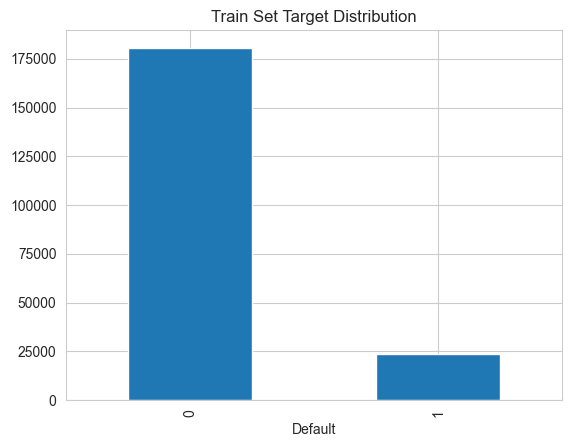

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Confirms the target is currently imbalanced.

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [53]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(361264, 22) (361264,) (51070, 22) (51070,)


Check Train Set Target distribution after resampling. 
The target is now balanced.

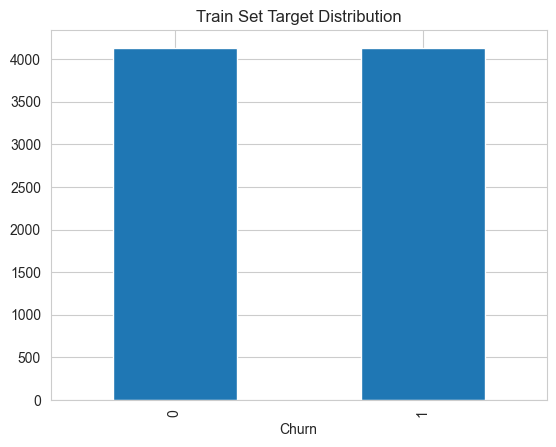

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

# Section 1

Section 1 content

---

# Section 2

Section 2 content

---

# Push files to Repo

In [ ]:
import joblib
import os

# Set the file_path and a version tag, which will be the folder name.
# It's appropriate since it's a form of version control.
version = 'v1'
file_path = f'.../{version}'
variable_to_save = df # or pipeline
filename = "dataset.csv" # or "pipeline.pkl"

# Try to generate output folder
try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

# Save the dataset as csv file for further use
variable_to_save.to_csv(f"{file_path}/{filename}", index=False)

# Save the variable as pkl file for further use
joblib.dump(value=variable_to_save ,
            filename=f"{file_path}/{filename}")


%matplotlib inline 
import matplotlib.pyplot as plt

# Save the figure as png file for further use
plt.savefig(f"{file_path}/{filename}", bbox_inches='tight',dpi=150)


---

# Conclusions and Next Steps

* Fill in conclusions and next steps